

# A forecast of the impact of AI and Crypto Minning in Global Energy Consumption


A predictive modelling of the future impact of AI and Crypto Mining in the world energy cnsumption.


## Content

* [1. Problem Statement](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Feature Selection](#3.2)
    * [4.3.Data Transformation](#3.3)
        * [4.3.1 Rescaling ](#3.3.1)
        * [4.3.2 Standardization](#3.3.2)
        * [4.3.3 Normalization](#3.3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Common Regression Models](#4.3.1)
        * [5.3.2 Ensemble Models](#4.3.2)
        * [5.3.3 Deep Learning Models](#4.3.3)  
    * [5.4. Time Series based Models-ARIMA and LSTM](#4.4)
        * [5.4.1 ARIMA Model](#4.4.1)
        * [5.4.2 LSTM Model](#4.4.2)
* [6. Model Tuning and Grid Search](#5)
    * [6.1 Common Regression, Ensemble and DeepNNRegressor Grid Search](#5.1)
    * [6.2 ARIMA and LSTM Grid Search](#5.2)
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2)
    * [7.3. Save model for later use](#6.3)


<a id='0'></a>
# 1. Problem Statement

The goal in this jupyter notebook is to create a pipeline to analyze the problem of enegy consumption prediction in the next 10 years, evaluating the increase in demand by AI and Minning of Crypto currencies.
The pipeline is based on the following steps:
- Load the data avaliable in csv files and other sources from IEA (International Energy Agency) https://www.iea.org/
- Transform the data applying the required formats and merging the datasets
- Plot and analyze the statistics to understand patterns and prepare data to training in machine learning models
- Apply ensemble methods and tuning of ensemble methods to improve model performance.
- The Following Models are implemented and evaluated

    * Ada Boost
    * Gradient Boosting Method
    * Random Forest
    * Extra Trees
    * Neural Network - Shallow - Using sklearn
    * Deep Neural Network - Using Keras
- Time Series Models
    * ARIMA Model
    * LSTM - Using Keras
    

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [54]:
# Load libraries
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from scikeras.wrappers import KerasClassifier

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

<a id='1.2'></a>
## 2.2. Loading the Data

In [55]:
# load dataset

bitcoin = pd.read_excel('Bitcoin_Energy.xlsx')

etherium = pd.read_csv('Historical Ethereum network annualised electricity consumption (PoS).csv')

In [56]:
# Transforming the datasets

# Converting the column Date and Time of Bitcoin and Etherium to date
bitcoin['Date and Time'] = pd.to_datetime(bitcoin['Date and Time'], errors='coerce')

etherium['Date and Time'] = pd.to_datetime(etherium['Date and Time'], errors='coerce')

# Conveting Etherium Consumption from GWh to TWh
etherium.iloc[:,4:] =  etherium.iloc[:,4:]/1000

etherium.columns = etherium.columns.str.split(',').str[0]

bitcoin.columns = etherium.columns.str.split(',').str[0]

# Merging both crypto datasets
crypto = pd.merge(bitcoin[['Date and Time','annualised consumption MAX']], etherium[['Date and Time','annualised consumption GUESS']], on= 'Date and Time',how='left')

# Summarising data by year
crypto_year = crypto.groupby(crypto['Date and Time'].dt.year)[['annualised consumption MAX','annualised consumption GUESS']].mean().reset_index()

crypto_year.fillna(0, inplace=True)

crypto_year['Consumption'] = crypto_year['annualised consumption MAX'] + crypto_year['annualised consumption GUESS']

crypto_year.drop(columns=['annualised consumption MAX','annualised consumption GUESS'], inplace=True)

crypto_year = crypto_year.rename(columns={'Date and Time':'Year'})

# Creating the dataframe of Data Center Energy consumption with data provided by IEA
datacenter = pd.DataFrame({'Year':list(range(2014,2025)), 'Consumption':[194, 191, 195, 195, 198, 192, 269, 300, 330, 361, 416]})

# Merging Crypto and Data Centers in a single dataframe
crypto_datacenter = pd.merge(crypto_year, datacenter, on='Year', how='inner')

crypto_datacenter['Total Consumption'] = crypto_datacenter['Consumption_x'] +  crypto_datacenter['Consumption_y']

crypto_datacenter.drop(columns=['Consumption_x', 'Consumption_y'], inplace=True)

In [57]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [58]:
# Crypto and Data Center shape
crypto_datacenter.shape

(11, 2)

In [59]:
# Crypto and Data Center types
pd.set_option('display.max_rows', 500)
crypto_datacenter.dtypes

Year                   int32
Total Consumption    float64
dtype: object

In [60]:
# describe Crypto and Data Center data
pd.set_option('display.precision', 3)
crypto_datacenter.describe()

,Year,Total Consumption
count,11.000,11.000
mean,2019.000,317.938
std,3.317,132.642
min,2014.000,194.621
25%,2016.500,204.328
50%,2019.000,246.667
75%,2021.500,407.331
max,2024.000,574.396


<a id='2.2'></a>
## 3.2. Data Visualization

In [61]:
# Plotting individual charts to analyze the patterns - Crypto and Data Centers Energy Consumption
fig = px.line(crypto_datacenter, x='Year', y=['Total Consumption'], color_discrete_sequence=['red'], title="Total Energy Consumption by Crypto Minning and Datacenters", height=500, width=1000)
fig.show()

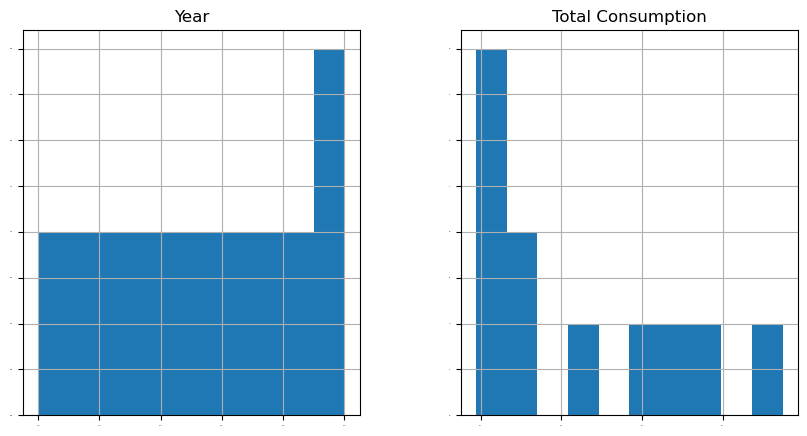

In [62]:
# histograms
crypto_datacenter.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(10,5))

pyplot.show()

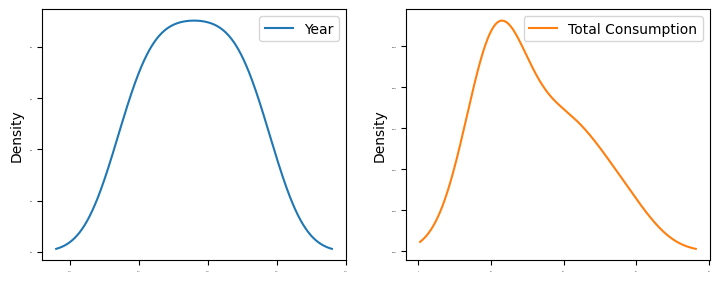

In [63]:
# density
crypto_datacenter.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=True, fontsize=1, figsize=(18,15))
pyplot.show()

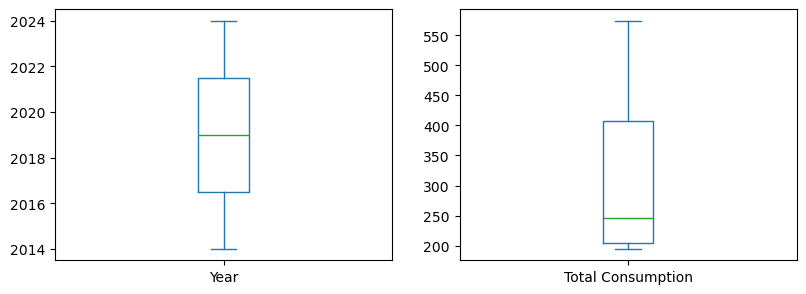

In [64]:
#Box and Whisker Plots
crypto_datacenter.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,15))
pyplot.show()

<Figure size 1200x1200 with 0 Axes>

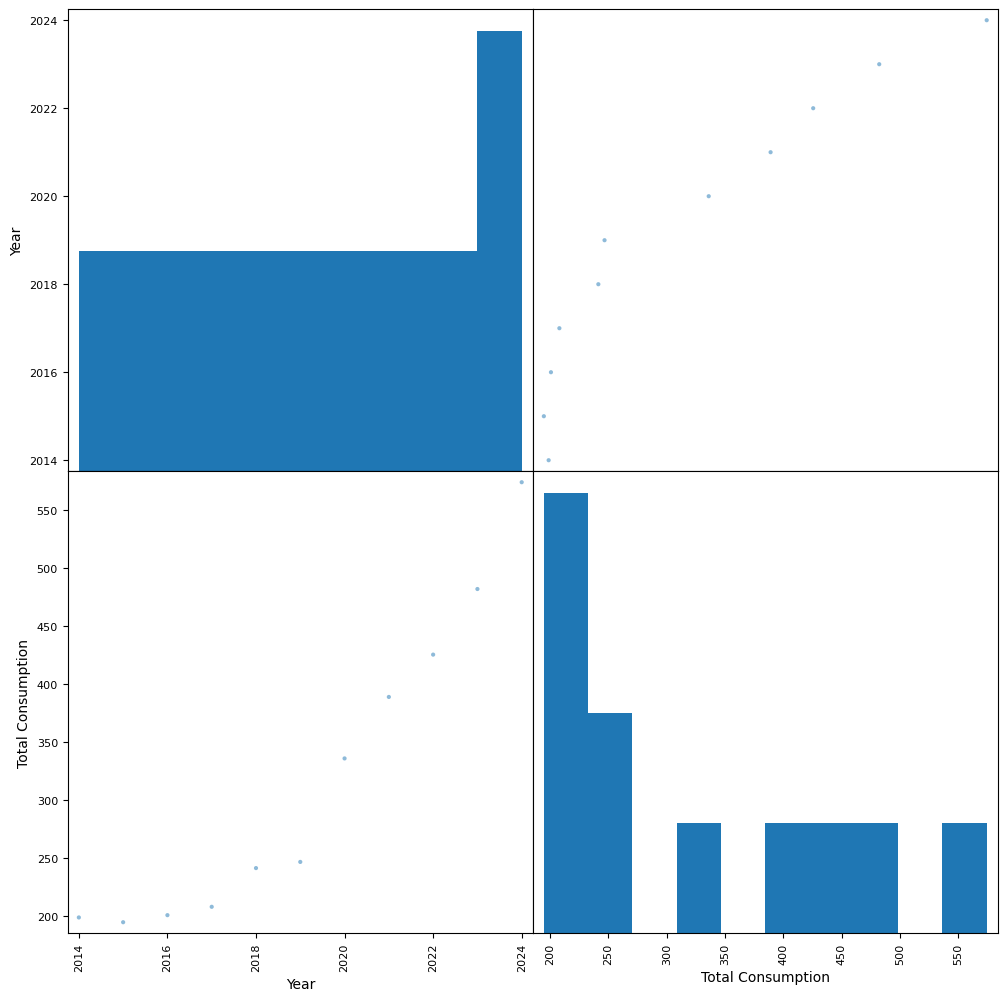

In [65]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
pyplot.figure(figsize=(12,12))
scatter_matrix(crypto_datacenter,figsize=(12,12))
pyplot.show()

<a id='2.3'></a>
## 3.3. Time Series Analysis

Time series broken down into different time series comonent

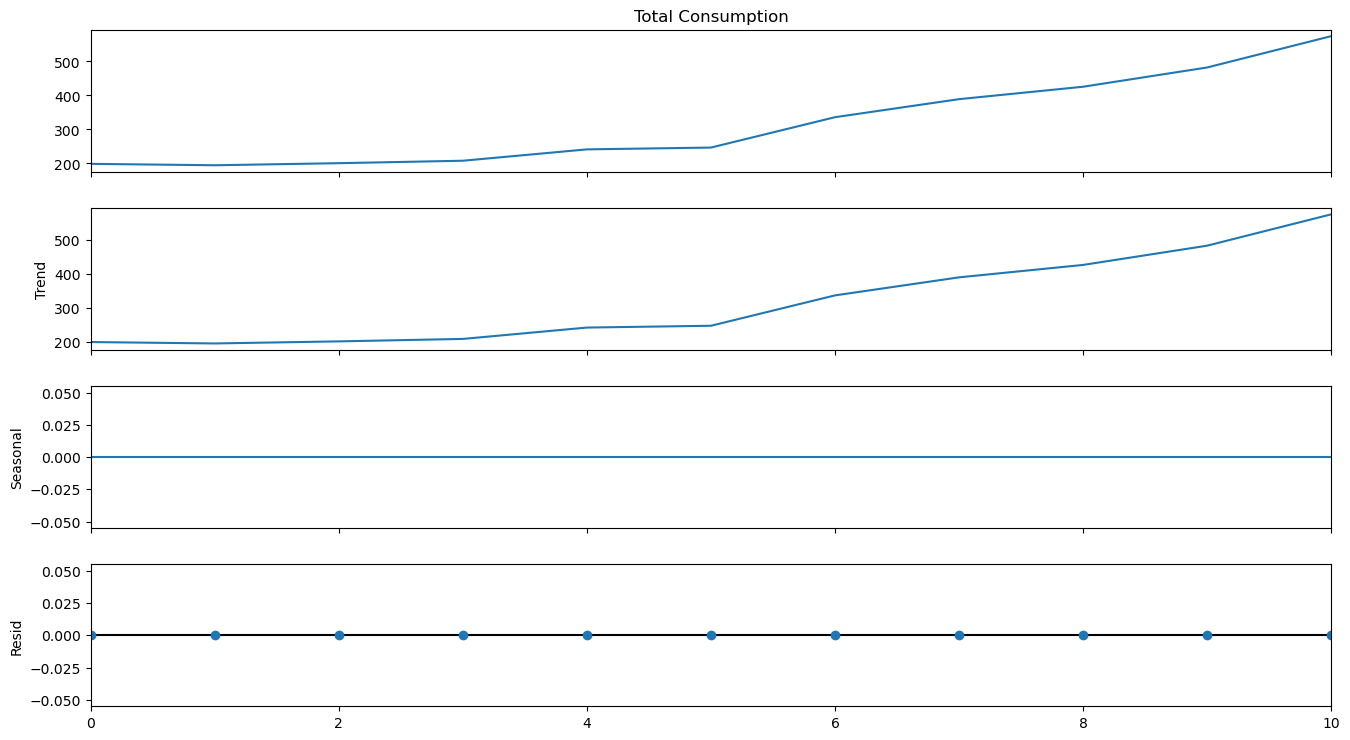

In [66]:
Y= crypto_datacenter["Total Consumption"]
res = sm.tsa.seasonal_decompose(Y, period=1)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [67]:
#Checking for any null values and removing the null values'''
print('Null Values =',crypto_datacenter.isnull().values.any())

Null Values = False


Given that there are null values drop the rown contianing the null values.

In [68]:
# Drop the rows containing NA
#dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

#Filling the NAs with the mean of the column.
#dataset['col'] = dataset['col'].fillna(dataset['col'].mean())

<a id='3.3'></a>
## 4.3. Spliting train and validation set

In [69]:
Ycd= crypto_datacenter['Total Consumption']
Xcd = crypto_datacenter.loc[:,crypto_datacenter.columns != 'Total Consumption']

<a id='3.4'></a>
## 4.4. Data Transformation

<a id='3.4.1'></a>
### 4.4.1. Rescale Data
When your data is comprised of attributes with varying scales, many machine learning algorithms
can benefit from rescaling the attributes to all have the same scale. Often this is referred to
as normalization and attributes are often rescaled into the range between 0 and 1.

In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledXcd = pd.DataFrame(scaler.fit_transform(Xcd))
# summarize transformed data
rescaledXcd.head(5)

,0
0,0.0
1,0.1
2,0.2
3,0.3
4,0.4


<a id='3.4.2'></a>
### 4.4.2. Standardize Data
Standardization is a useful technique to transform attributes with a Gaussian distribution and
differing means and standard deviations to a standard Gaussian distribution with a mean of
0 and a standard deviation of 1.

In [71]:
from sklearn.preprocessing import StandardScaler
scaler_cd = StandardScaler().fit(Xcd)
StandardisedX_cd = pd.DataFrame(scaler_cd.fit_transform(Xcd))
# summarize transformed data
StandardisedX_cd.head(5)

,0
0,-1.581
1,-1.265
2,-0.949
3,-0.632
4,-0.316


<a id='3.4.3'></a>
### 4.4.1. Normalize Data
Normalizing in scikit-learn refers to rescaling each observation (row) to have a length of 1 (called
a unit norm or a vector with the length of 1 in linear algebra).

In [72]:
from sklearn.preprocessing import Normalizer
scaler_cd = Normalizer().fit(Xcd)
NormalizedX_cd = pd.DataFrame(scaler_cd.fit_transform(Xcd))
# summarize transformed data
NormalizedX_cd.head(5)

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

In [73]:
# split out validation dataset for the end
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.

train_size_cd = int(len(Xcd) * (1-validation_size))
X_train_cd, X_validation_cd = Xcd[0:train_size_cd], Xcd[train_size_cd:len(Xcd)]
Y_train_cd, Y_validation_cd = Ycd[0:train_size_cd], Ycd[train_size_cd:len(Xcd)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [74]:
# test options for regression
num_folds = 8
scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
#scoring = 'r2'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1. Common Models

In [75]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
#models.append(('MLP', MLPRegressor()))

<a id='4.3.2'></a>
### 5.3.2. Ensemble Models

In [76]:
#Ensable Models
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

<a id='4.3.3'></a>
### 5.3.3. Deep Learning Model-NN Regressor

In [77]:
#Running deep learning models and performing cross validation takes time
#Set the following Flag to 0 if the Deep LEarning Models Flag has to be disabled
EnableDeepLearningRegreesorFlag = 0

def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # create model
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        #The number of hidden layers can be increased
        model.add(Dense(2, activation=activation))
        # Final output layer
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model

In [78]:
#Add Deep Learning Regressor
if ( EnableDeepLearningRegreesorFlag == 1):
    models.append(('DNN', KerasRegressor(build_fn=create_model, epochs=100, batch_size=100, verbose=1)))


### K-folds cross validation - Crypto and AI

In [79]:
results_cd = []
names_cd = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results_cd = -1* cross_val_score(model, X_train_cd, Y_train_cd, cv=kfold, scoring=scoring)
    results_cd.append(cv_results_cd)
    names_cd.append(name)
    msg = "%s: %f (%f)" % (name, cv_results_cd.mean(), cv_results_cd.std())
    print(msg)

LR: 2045.759142 (2043.577665)
LASSO: 2047.817592 (2058.909486)
EN: 2015.989303 (2258.924847)
KNN: 3735.929711 (6542.082319)
CART: 1508.019669 (2614.271793)
SVR: 7090.946448 (10658.203324)


ABR: 1510.550479 (2612.836489)
GBR: 1508.072556 (2614.360577)
RFR: 1747.207962 (2973.035956)
ETR: 649.355901 (1002.739810)


### Algorithm comparison

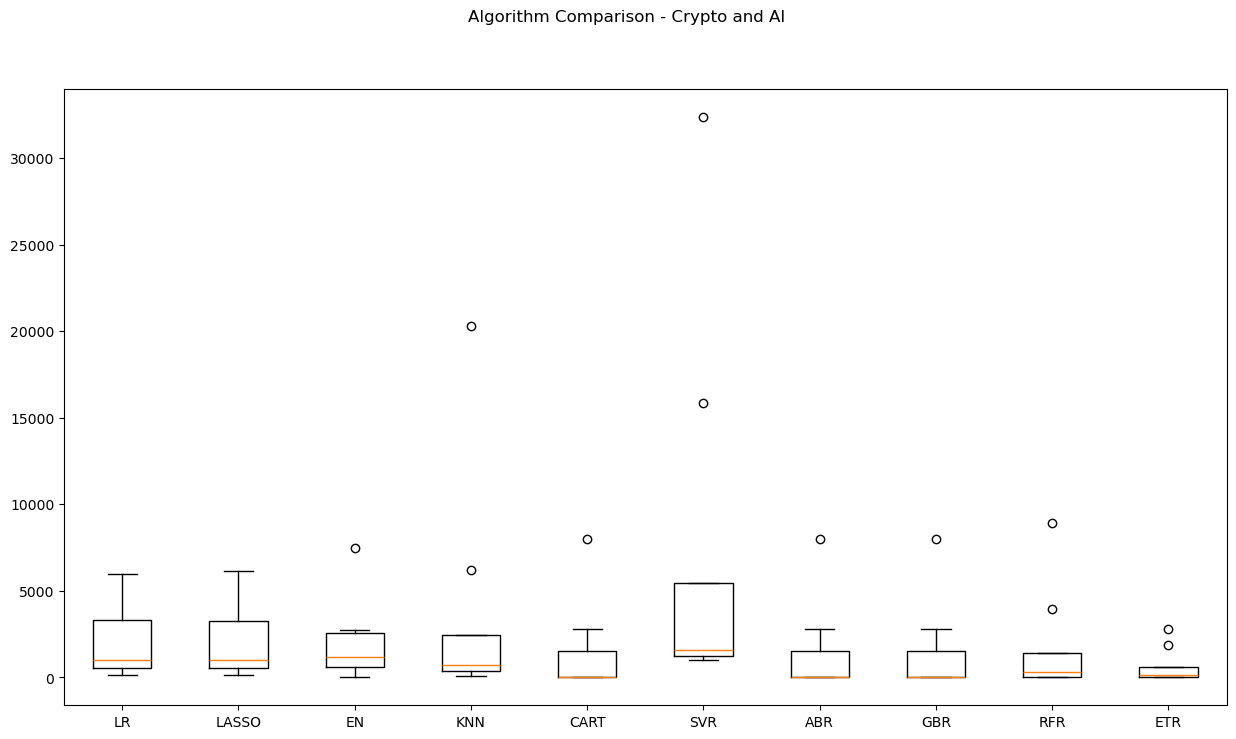

In [80]:
# compare algorithms - Crypto and AI
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Crypto and AI')
ax = fig.add_subplot(111)
pyplot.boxplot(results_cd)
ax.set_xticklabels(names_cd)
fig.set_size_inches(15,8)
pyplot.show()

The chart shows MSE. Lower the MSE, better is the model performance.

<a id='4.4'></a>
## 5.4. Time Series based Models - ARIMA and LSTM

<a id='4.4.1'></a>
### 5.4.1 Time Series Model - ARIMA Model

In [81]:
#Preparing data for the ARIMAX Model, seperating endogeneous and exogenous variables
# Crypto and AI
X_train_ARIMA_cd = X_train_cd
X_validation_ARIMA_cd =X_validation_cd
tr_len_cd = len(X_train_ARIMA_cd)
te_len_cd = len(X_validation_ARIMA_cd)
to_len_cd = len(Xcd)

In [82]:
# ARIMA Crypto and AI
from statsmodels.tsa.arima.model import ARIMA # Corrected import path
# from statsmodels.tsa.statespace.sarimax import SARIMAX # Keep this if you need SARIMAX later

from sklearn.metrics import mean_squared_error

modelARIMA_cd = ARIMA(endog = Y_train_cd, exog = X_train_ARIMA_cd, order=(1,0,0)) # Note: order is a tuple
# modelARIMA= SARIMAX(Y_train,order=(1,1,0),seasonal_order=(1,0,0,0),exog = X_train_ARIMA)

model_fit_cd = modelARIMA_cd.fit()

print(model_fit_cd.summary())

                               SARIMAX Results                                
Dep. Variable:      Total Consumption   No. Observations:                    8
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -38.010
Date:                Tue, 12 Aug 2025   AIC                             84.019
Time:                        21:09:24   BIC                             84.337
Sample:                             0   HQIC                            81.876
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.284e+04   1.36e+04     -3.880      0.000   -7.95e+04   -2.61e+04
Year          26.3195      6.751      3.898      0.000      13.087      39.552
ar.L1          0.5279      0.405      1.304      0.1

In [83]:
error_Training_ARIMA_cd = mean_squared_error(Y_train_cd, model_fit_cd.fittedvalues)
predicted_cd = model_fit_cd.predict(start = tr_len_cd -1 ,end = to_len_cd -1, exog = X_validation_ARIMA_cd)[1:]
error_Test_ARIMA_cd = mean_squared_error(Y_validation_cd, predicted_cd)
error_Test_ARIMA_cd

7970.760155332744

In [84]:
#Add Cross validation if possible
# #model = build_model(_alpha=1.0, _l1_ratio=0.3)
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)
# scores = cross_val_score(modelARIMA, X_train, Y_train, cv=tscv, scoring=scoring)

<a id='4.4.2'></a>
### 5.4.2 LSTM Model

The data needs to be in 3D format for the LSTM model. So, Performing the data transform.

In [85]:
# LSTM training - Crypto and AI
X_train_LSTM_cd, X_validation_LSTM_cd = np.array(X_train_cd), np.array(X_validation_cd)
Y_train_LSTM_cd, Y_validation_LSTM_cd = np.array(Y_train_cd), np.array(Y_validation_cd)
X_train_LSTM_cd = X_train_LSTM_cd.reshape((X_train_LSTM_cd.shape[0], 1, X_train_LSTM_cd.shape[1]))
X_validation_LSTM_cd = X_validation_LSTM_cd.reshape((X_validation_LSTM_cd.shape[0], 1, X_validation_LSTM_cd.shape[1]))
print(X_train_LSTM_cd.shape, Y_train_LSTM_cd.shape, X_validation_LSTM_cd.shape, Y_validation_LSTM_cd.shape)

(8, 1, 1) (8,) (3, 1, 1) (3,)


In [86]:
# design network - Crypto and AI
from matplotlib import pyplot

def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0.1):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM_cd.shape[1], X_train_LSTM_cd.shape[2])))
    #More number of cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(learning_rate=learn_rate, momentum=0.1)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel_cd = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit_cd = LSTMModel_cd.fit(X_train_LSTM_cd, Y_train_LSTM_cd, validation_data=(X_validation_LSTM_cd, Y_validation_LSTM_cd),epochs=50, batch_size=24, verbose=0, shuffle=False)# plot history


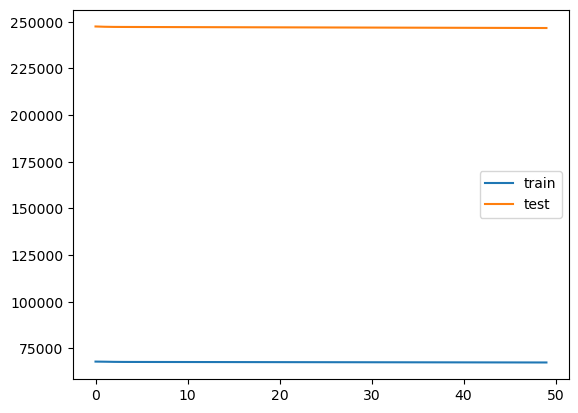

In [87]:
#Visual plot to check if the error is reducing- Crypto and AI
pyplot.plot(LSTMModel_fit_cd.history['loss'], label='train')
pyplot.plot(LSTMModel_fit_cd.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [88]:
error_Training_LSTM_cd = mean_squared_error(Y_train_LSTM_cd, LSTMModel_cd.predict(X_train_LSTM_cd))
predicted_cd = LSTMModel_cd.predict(X_validation_LSTM_cd)
error_Test_LSTM_cd = mean_squared_error(Y_validation_cd, predicted_cd)
error_Test_LSTM_cd

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


246679.84554594322

### Overall Comparison of all the algorithms ( including Time Series Algorithms)

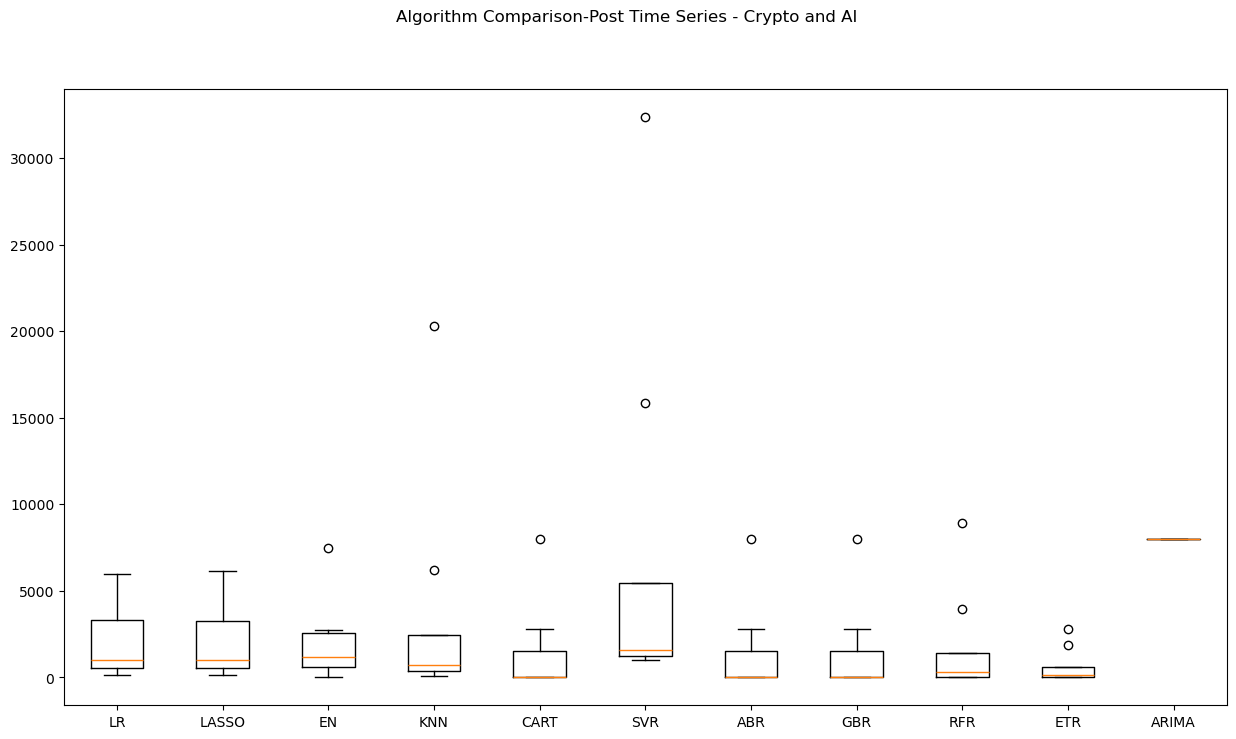

In [89]:
# compare algorithms - Crypto and AI
results_cd.append(error_Test_ARIMA_cd)
names_cd.append("ARIMA")
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison-Post Time Series - Crypto and AI')
ax = fig.add_subplot(111)
pyplot.boxplot(results_cd)
ax.set_xticklabels(names_cd)
fig.set_size_inches(15,8)
pyplot.show()

Grid Search uses Cross validation which isn't appropriate for the time series models such as LSTM

<a id='5'></a>
# 6. Model Tuning and Grid Search
This section shown the Grid search for all the Machine Learning and time series models mentioned in the book.

<a id='5.1'></a>
### 6.1. Common Regression, Ensemble and DeepNNRegressor Grid Search


Grid Search Crypto and AI

In [90]:
# 8. Grid search : RandomForestRegressor - Crypto and AI
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': [5,10,20,30,50,100,150,200]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_cd, Y_train_cd)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -1149.381140 using {'n_estimators': 5}
-1149.381140 (1968.638121) with: {'n_estimators': 5}
-1693.228853 (3682.163601) with: {'n_estimators': 10}
-1533.374761 (2731.197821) with: {'n_estimators': 20}
-1255.933955 (1840.917045) with: {'n_estimators': 30}
-1390.647228 (2111.197192) with: {'n_estimators': 50}
-1277.624312 (2309.692074) with: {'n_estimators': 100}
-1486.903011 (2478.766057) with: {'n_estimators': 150}
-1320.561040 (2297.547183) with: {'n_estimators': 200}


In [91]:
# 10. Grid search : ExtraTreesRegressor - Crypto and AI
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': [5,10,20,30,50,100,150,200]}
model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_cd, Y_train_cd)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -418.238783 using {'n_estimators': 10}
-477.117711 (905.713727) with: {'n_estimators': 5}
-418.238783 (917.462357) with: {'n_estimators': 10}
-498.405592 (893.546805) with: {'n_estimators': 20}
-509.212160 (896.945506) with: {'n_estimators': 30}
-623.333212 (943.749216) with: {'n_estimators': 50}
-630.440651 (951.980371) with: {'n_estimators': 100}
-637.821372 (981.343448) with: {'n_estimators': 150}
-681.442360 (1005.131239) with: {'n_estimators': 200}


In [92]:
# 11. Grid search : AdaBoostRegre - Crypto and AI
'''
n_estimators : integer, optional (default=50)
    The maximum number of estimators at which boosting is terminated.
    In case of perfect fit, the learning procedure is stopped early.

learning_rate : float, optional (default=1.)
    Learning rate shrinks the contribution of each regressor by
    ``learning_rate``. There is a trade-off between ``learning_rate`` and
    ``n_estimators``.
'''
param_grid = {'n_estimators': [10,20,30,50,100,150,200],
             'learning_rate': [1, 2, 3]}
model = AdaBoostRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_cd, Y_train_cd)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -1402.372654 using {'learning_rate': 2, 'n_estimators': 200}
-1507.742114 (2614.424789) with: {'learning_rate': 1, 'n_estimators': 10}
-1512.416401 (2611.788753) with: {'learning_rate': 1, 'n_estimators': 20}
-1645.462309 (2560.619455) with: {'learning_rate': 1, 'n_estimators': 30}
-1506.394657 (2615.202013) with: {'learning_rate': 1, 'n_estimators': 50}
-1510.550479 (2612.836489) with: {'learning_rate': 1, 'n_estimators': 100}
-1510.550479 (2612.836489) with: {'learning_rate': 1, 'n_estimators': 150}
-1510.550479 (2612.836489) with: {'learning_rate': 1, 'n_estimators': 200}
-1725.184594 (2544.884047) with: {'learning_rate': 2, 'n_estimators': 10}
-1647.906438 (2559.149308) with: {'learning_rate': 2, 'n_estimators': 20}
-1735.275479 (2538.190230) with: {'learning_rate': 2, 'n_estimators': 30}
-1735.275479 (2538.190230) with: {'learning_rate': 2, 'n_estimators': 50}
-1535.418562 (2599.175101) with: {'learning_rate': 2, 'n_estimators': 100}
-1535.418562 (2599.175101) with: {'learni

<a id='5.2'></a>
### 6.2. Grid Search- Time Series Models

In [93]:
#Grid Search for ARIMA Model - Crypto and AI
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()
    modelARIMA_cd = ARIMA(endog=Y_train_cd,exog=X_train_ARIMA_cd,order=arima_order)
    model_fit_cd = modelARIMA_cd.fit()
    #error on the test set
#     tr_len = len(X_train_ARIMA)
#     to_len = len(X_train_ARIMA) + len(X_validation_ARIMA)
#     predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_validation_ARIMA)[1:]
#     error = mean_squared_error(predicted, Y_validation)
    # error on the training set
    error = mean_squared_error(Y_train_cd, model_fit_cd.fittedvalues)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 3]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=950.1566218
ARIMA(0, 0, 1) MSE=754.7051422
ARIMA(0, 0, 2) MSE=683.9668280
ARIMA(0, 1, 0) MSE=372121769.4316639
ARIMA(0, 1, 1) MSE=459944230.7085168
ARIMA(0, 1, 2) MSE=931944363.9965873
ARIMA(0, 2, 0) MSE=7522.1634930
ARIMA(0, 2, 1) MSE=159802419.9460371
ARIMA(0, 2, 2) MSE=52180817.9471145
ARIMA(1, 0, 0) MSE=783.0581873
ARIMA(1, 0, 1) MSE=736.8714178
ARIMA(1, 0, 2) MSE=640.4663773
ARIMA(1, 1, 0) MSE=649325231.3021702
ARIMA(1, 1, 1) MSE=440103033.6806315
ARIMA(1, 1, 2) MSE=161853951792.2311401
ARIMA(1, 2, 0) MSE=20619459.7733251
ARIMA(1, 2, 1) MSE=19347519.7799989
ARIMA(1, 2, 2) MSE=49616060.2632297
ARIMA(2, 0, 0) MSE=675.2885706
ARIMA(2, 0, 1) MSE=482.3271686
ARIMA(2, 0, 2) MSE=473.5700643
ARIMA(2, 1, 0) MSE=3252408370.8927979
ARIMA(2, 1, 1) MSE=132878557897.7797394
ARIMA(2, 1, 2) MSE=980526145.9291437
ARIMA(2, 2, 0) MSE=3691466.7626322
ARIMA(2, 2, 1) MSE=8715364.9948638
ARIMA(2, 2, 2) MSE=123700751.7046908
ARIMA(3, 0, 0) MSE=491.9830312
ARIMA(3, 0, 1) MSE=428.9693767

<a id='6'></a>
# 7. Finalise the Model

Let us select one of the model to finalize the data. Looking at the results for the Random Forest Model. Looking at the results for the RandomForestRegressor model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [94]:
# Fit model - Crypto and AI
# prepare model
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
model_cd_et = ExtraTreesRegressor(n_estimators=10) # rbf is default kernel
model_cd_et.fit(X_train_cd, Y_train_cd)

# ARIMA
modelARIMA_cd = ARIMA(endog = Y_train_cd, exog = X_train_ARIMA_cd, order=(3,0,1)) # Note: order is a tuple
model_fit_ARIMA_cd = modelARIMA_cd.fit()
# Fitting the ARIMA model
error_Training_ARIMA_cd = mean_squared_error(Y_train_cd, model_fit_ARIMA_cd.fittedvalues)

In [95]:
# Evaluate ARIMA Model parameters
print(model_fit_ARIMA_cd.summary())

                               SARIMAX Results                                
Dep. Variable:      Total Consumption   No. Observations:                    8
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 -35.862
Date:                Tue, 12 Aug 2025   AIC                             85.725
Time:                        21:10:15   BIC                             86.281
Sample:                             0   HQIC                            81.974
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.284e+04      7e+04     -0.755      0.450    -1.9e+05    8.44e+04
Year          26.3157     34.755      0.757      0.449     -41.803      94.434
ar.L1          0.9415      1.682      0.560      0.5

In [96]:
# estimate accuracy on validation set - Crypto and AI
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
predictions_et_cd = model_cd_et.predict(X_validation_cd)
print('-'*50)
print('EXTRA TREES MODEL')
print('-'*50)
print('Mean Squared Error:',mean_squared_error(Y_validation_cd, predictions_et_cd))
print('r2 Score:', r2_score(Y_validation_cd, predictions_et_cd))

print('-'*50)
print('ARIMA MODEL')
print('-'*50)
predictions_arima_cd = model_fit_ARIMA_cd.predict(start = tr_len_cd - 1, end = to_len_cd - 1, exog = X_validation_ARIMA_cd)[1:]
print('Mean Squared Error:',mean_squared_error(Y_validation_cd, predictions_arima_cd))
print('r2 Score:', r2_score(Y_validation_cd, predictions_arima_cd))

--------------------------------------------------
EXTRA TREES MODEL
--------------------------------------------------
Mean Squared Error: 14786.875939802967
r2 Score: -2.9322846025537115
--------------------------------------------------
ARIMA MODEL
--------------------------------------------------
Mean Squared Error: 10095.320516297623
r2 Score: -1.6846558790166393


<a id='6.2'></a>
## 7.2. Concatenate and Plot results of Fitted and Real to comparate

In [97]:
# Creating a dataframe with the fitted values of ARIMA Model - Trainning Set
fitted = pd.DataFrame({'Fitted':model_fit_ARIMA_cd.fittedvalues})
comp_arima = pd.concat([X_train_ARIMA_cd, Y_train_cd, fitted], axis=1)
comp_arima.head()

,Year,Total Consumption,Fitted
0,2014,198.736,161.257
1,2015,194.621,206.307
2,2016,200.719,204.813
3,2017,207.937,214.266
4,2018,241.351,241.807


In [98]:
# Plotting the dataset with the Fitted Values from ARIMA to compare with the Real Values
fig = px.line(comp_arima, x= 'Year', y=['Total Consumption','Fitted'], color_discrete_sequence=['black', 'blue'], title="Total World Energy Consumption", height=500, width=1000)
# Loop through traces and set dash for 'Fitted'
for trace in fig.data:
    if trace.name == 'Fitted':
        trace.line.dash = 'dash'  # options: dash, dot, dashdot, etc.
fig.show()

In [99]:
# Creating a dataframe with the fitted values of ARIMA Model - Trainning Set
fitted_values_et = model_cd_et.predict(X_train_cd)
fitted_et = pd.DataFrame({'Fitted':fitted_values_et}, index=X_train_cd.index)
comp_et= pd.concat([X_train_cd, Y_train_cd, fitted_et], axis=1)
comp_et.head()

,Year,Total Consumption,Fitted
0,2014,198.736,198.736
1,2015,194.621,194.621
2,2016,200.719,200.719
3,2017,207.937,207.937
4,2018,241.351,241.351


In [100]:
# Plotting the dataset with the Fitted Values from Extra Trees to compare with the Real Values
fig = px.line(comp_et, x= 'Year', y=['Total Consumption','Fitted'], color_discrete_sequence=['black', 'red'], title="Total World Energy Consumption", height=500, width=1000)
# Loop through traces and set dash for 'Fitted'
for trace in fig.data:
    if trace.name == 'Fitted':
        trace.line.dash = 'dash'  # options: dash, dot, dashdot, etc.
fig.show()

In [101]:
# Creating a dataframe with the values of ARIMA Model - Validation Set
ARIMA_val = pd.merge(X_validation_ARIMA_cd, Y_validation_cd, left_index=True, right_index=True)
ARIMA_validation = pd.merge(ARIMA_val, predictions_arima_cd, left_index=True, right_index=True)
ARIMA_validation.head()

,Year,Total Consumption,predicted_mean
8,2022,425.597,413.103
9,2023,482.223,416.968
10,2024,574.396,413.549


In [102]:
# Plotting The Validation set of ARIMA model to evaluate the performance
fig = px.line(ARIMA_validation, x= 'Year', y=['Total Consumption','predicted_mean'], color_discrete_sequence=['blue', 'red'], title="Total World Energy Consumption", height=500, width=1000)
fig.show()

In [103]:
# Creating a dataframe with the fitted values of Extra Trees Model - Validation Set
fitted_values_et = model_cd_et.predict(X_validation_cd)
fitted_et = pd.DataFrame({'Predicted':fitted_values_et}, index=X_validation_cd.index)
comp_et= pd.concat([X_validation_cd, Y_validation_cd, fitted_et], axis=1)
comp_et.head()

,Year,Total Consumption,Predicted
8,2022,425.597,389.065
9,2023,482.223,389.065
10,2024,574.396,389.065


In [104]:
# Plotting the dataset with the Fitted Values from Extra Trees to compare with the Real Values
fig = px.line(comp_et, x= 'Year', y=['Total Consumption','Predicted'], color_discrete_sequence=['black', 'red'], title="Total World Energy Consumption", height=500, width=1000)
# Loop through traces and set dash for 'Fitted'
for trace in fig.data:
    if trace.name == 'Predicted':
        trace.line.dash = 'dash'  # options: dash, dot, dashdot, etc.
fig.show()

<a id='6.3'></a>
## 7.3. Save Model for Later Use

In [105]:
# ARIMA
modelARIMA_cd = ARIMA(endog = Ycd, exog = Xcd, order=(3,0,1)) # Note: order is a tuple
model_fit_ARIMA_cd = modelARIMA_cd.fit()

In [106]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'Models/crypto_ai_forecast.sav'
dump(model_fit_ARIMA_cd, open(filename, 'wb'))